In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt

Mencari Unsupported Image

In [2]:
from pathlib import Path
import filetype

# RFC image file extensions supported by TensorFlow
img_exts = {"png", "jpg", "gif", "bmp"}

def searchUnsupportedImages(path):
    for file in path.iterdir():
        if file.is_dir():
            continue

        ext = filetype.guess_extension(file)

        if ext is None:
            print(f"'{file}': extension cannot be guessed from content")
        elif ext not in img_exts:
            print(f"'{file}': not a supported image file")

In [3]:
path1 = Path("Dataset/Olaf")
path2 = Path("Dataset/Woody")
path3 = Path("Dataset/Bolt")
path4 = Path("Dataset/Carl")

searchUnsupportedImages(path1)
searchUnsupportedImages(path2)
searchUnsupportedImages(path3)
searchUnsupportedImages(path4)

PERSIAPAN DATASET

In [4]:
data_dir = './Dataset/'

In [5]:
#BATCH UKURAN 16, IMAGE SESUAI MODEL
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224,224),batch_size=16)
print(data.class_names)
class_names=data.class_names

Found 679 files belonging to 4 classes.
['Bolt', 'Carl', 'Olaf', 'Woody']


In [6]:
data_iterator = data.as_numpy_iterator()
print("data_iterator", data_iterator)

data_iterator <tensorflow.python.data.ops.dataset_ops.NumpyIterator object at 0x0000025B8AF0DAD0>


In [7]:
batch = data_iterator.next()
print("batch", batch)

batch (array([[[[122.44771  ,  95.42857  ,  87.71301  ],
         [122.       ,  95.       ,  87.64286  ],
         [116.07143  ,  89.07143  ,  82.07143  ],
         ...,
         [150.       ,  74.93497  ,  87.93497  ],
         [142.77171  ,  67.77171  ,  80.77171  ],
         [134.32149  ,  59.32148  ,  72.32148  ]],

        [[121.85715  ,  94.79975  ,  87.79975  ],
         [121.26785  ,  94.26785  ,  87.       ],
         [116.07143  ,  89.07143  ,  82.07143  ],
         ...,
         [153.14415  ,  78.125015 ,  91.125015 ],
         [148.26785  ,  73.26785  ,  86.26785  ],
         [143.07143  ,  68.07143  ,  81.07143  ]],

        [[122.625    ,  95.19005  ,  88.19005  ],
         [121.       ,  93.       ,  86.       ],
         [116.07143  ,  89.07143  ,  82.07143  ],
         ...,
         [134.58545  ,  60.624985 ,  74.624985 ],
         [139.50127  ,  65.21429  ,  79.05483  ],
         [142.44643  ,  68.21423  ,  82.21423  ]],

        ...,

        [[ 65.337425 ,  43.7659

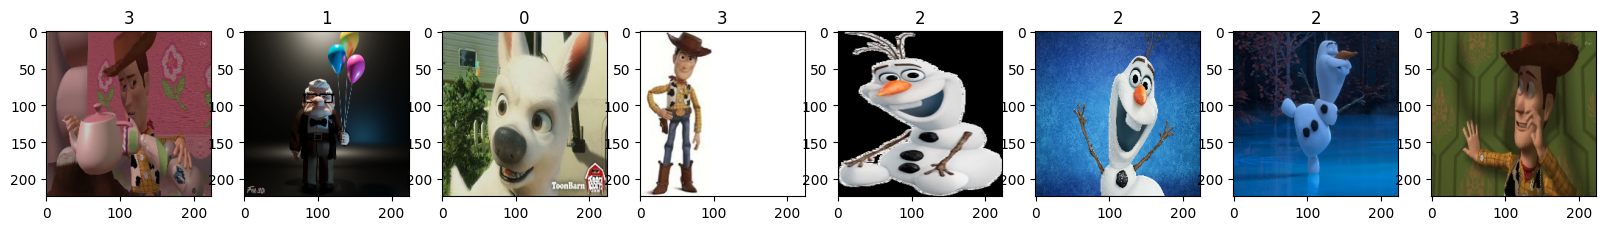

In [8]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
data = data.map(lambda x, y: (x/255.0, y))
print("Data type after normalization: {}".format(data.element_spec))
print("Data shape after normalization: {}".format(data.element_spec))
print("Jumlah data", len(data))


Data type after normalization: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Data shape after normalization: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Jumlah data 43


BAGI DATASET JADI 3 BAGIAN: TRAIN, VALIDASI, TESTING

In [10]:
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = int(0.1 * len(data))

print(train_size)
print(val_size)
print(test_size)

34
4
4


In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

MODEL VGGNet

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

In [13]:
#inisisasi model kosong
model = Sequential()

In [14]:
# 13 convolutional layers dan 5 max-pooling layers

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Block 4
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Block 5
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

In [15]:
# Flatten the output for the fully connected layers
model.add(Flatten())

In [16]:
# 3 Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

In [17]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 0.001 * (0.9 ** epoch)
    return lr

model.compile(optimizer=Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lr_scheduler = LearningRateScheduler(lr_schedule)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      3

In [19]:
history = model.fit(train, validation_data=val, epochs=35, callbacks=[lr_scheduler])

Epoch 1/35




34/34 [==============================] - 343s 10s/step - loss: 2.3336 - accuracy: 0.3107 - val_loss: 1.4826 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 2/35
34/34 [==============================] - 375s 11s/step - loss: 1.4190 - accuracy: 0.4357 - val_loss: 1.4690 - val_accuracy: 0.2500 - lr: 9.0000e-04
Epoch 3/35
34/34 [==============================] - 319s 9s/step - loss: 1.3030 - accuracy: 0.5018 - val_loss: 1.5468 - val_accuracy: 0.2812 - lr: 8.1000e-04
Epoch 4/35
34/34 [==============================] - 339s 10s/step - loss: 1.1642 - accuracy: 0.5276 - val_loss: 1.7389 - val_accuracy: 0.1562 - lr: 7.2900e-04
Epoch 5/35
34/34 [==============================] - 284s 8s/step - loss: 1.0232 - accuracy: 0.6085 - val_loss: 2.4593 - val_accuracy: 0.1875 - lr: 6.5610e-04
Epoch 6/35
34/34 [==============================] - 296s 9s/step - loss: 0.9230 - accuracy: 0.6213 - val_loss: 2.0706 - val_accuracy: 0.1719 - lr: 5.9049e-04
Epoch 7/35
34/34 [==============================] - 293s 9s/st

In [20]:
import pandas as pd
#pip install openpyxl

# Convert the training history to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame to an Excel file
history_df.to_excel('History_VGG_B_SB 4.xlsx', index=False)

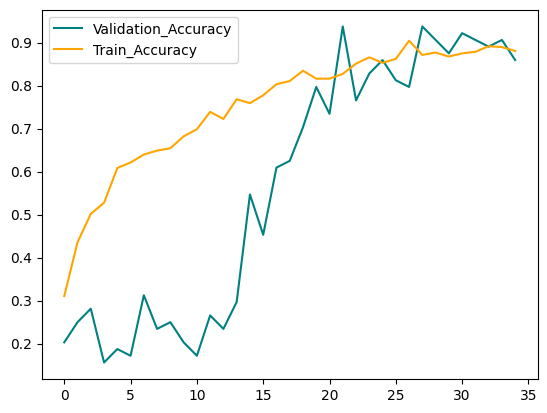

In [21]:
fig = plt.figure()
plt.plot(history.history['val_accuracy'], color='teal', label='Validation_Accuracy')
plt.plot(history.history['accuracy'], color='orange', label='Train_Accuracy')
plt.legend(loc="upper left")
plt.show()

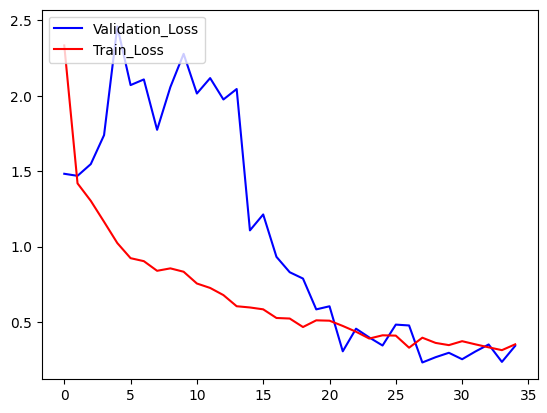

In [22]:
fig = plt.figure()
plt.plot(history.history['val_loss'], color='blue', label='Validation_Loss')
plt.plot(history.history['loss'], color='red', label='Train_Loss')
plt.legend(loc="upper left")
plt.show()

In [23]:
model.evaluate(test)

4/4 [==============================] - 13s 1s/step - loss: 0.1948 - accuracy: 0.9219


[0.1948060542345047, 0.921875]

In [24]:
model.save('model_vgg16.h5')

c:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
